In [1]:
%matplotlib inline
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
colors = sns.color_palette('muted')
nax = np.newaxis

We represent molecules in a grid format amenable to convolutional network training. To convert molecules to this format, we assign each atom a type based on a typing scheme that includes the element, aromaticity, hydrophobicity, and H-bond donor/acceptor state. Then, atoms are represented as continuous, Gaussian-like densities on a three-dimensional grid with separate channels for each atom type, analogous to an RGB image. The density of an atom at a grid point is a function of the displacement and the atomic radius:

\begin{align}
    f_t(c) =
    \begin{cases}
    e^{-2(\frac{\|c\|}{r_t})^2} & 0 \leq \|c\| < r_t \\
    \frac{4}{e^2}(\frac{\|c\|}{r_t})^2 - \frac{12}{e^2}\frac{\|c\|}{r_t} + \frac{9}{e^2} & r_t \leq \|c\| < \frac{3}{2}r_t \\
    0 & \frac{3}{2}r_t \leq \|c\| \\
    \end{cases} \\
\end{align}

Given a 3D molecular structure with $N$ atoms and $N_T$ possible atom types as a vector of atom type indices $T \in [1, N_T]^N$ and a matrix of atomic coordinates $C \in \mathbb{R}^{N \times 3}$, the grid values in each atom type channel are computed by summing the density of each atom with the corresponding type at each grid point.

\begin{align*}
    \label{eqn:atom_gridding}
    g(T, C)_{t,x,y,z} = \sum_{i=1}^{N} \mathbf{1}(T_i=t)  f_t(C_i - (x,y,z))
\end{align*}

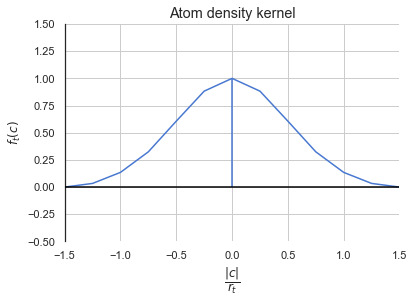

In [2]:
def get_grid_points(center, dimension, resolution):
    n_points = int(np.ceil(dimension/resolution + 1))
    return np.linspace(center - dimension/2, center + dimension/2, n_points)

def get_atom_density(atom_coord, atom_radius, grid_points):
    dist2 = np.sum((atom_coord - grid_points)**2, axis=-1)
    dist = np.sqrt(dist2)
    r, r2 = atom_radius, atom_radius**2
    ie2 = np.exp(-2)
    gauss_val = np.exp(-2*dist2/r2)
    quad_val = 4*ie2*dist2/r2 - 12*ie2*dist/r + 9*ie2
    return np.where(dist < r,     gauss_val, 
           np.where(dist < 1.5*r, quad_val, 0))

resolution = 0.25

atom_radius = 1.9 # carbon
bond_length = 1.4 # benzene
atom_radius = 1.0

kernel_dimension = (int(np.ceil(2*1.5*atom_radius/resolution + 1)) - 1)*resolution
kernel_points = get_grid_points(center=0.0, dimension=kernel_dimension, resolution=resolution)
kernel = get_atom_density(0, atom_radius, kernel_points[:,nax])

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(kernel_points, kernel, color=colors[0])
x_min, x_max = kernel_points.min(), kernel_points.max()
ax.hlines(0, x_min, x_max, zorder=10)
ax.vlines(0, 0, 1, color=colors[0])
ax.set_xlim(x_min, x_max)
ax.set_ylim(-0.5, 1.5)
#ax.set_xticks(kernel_points)
ax.set_title('Atom density kernel', fontsize='large')
ax.set_xlabel(r'$\dfrac{\|c\|}{r_t}$')
ax.set_ylabel('$f_t(c)$')
ax.grid(True)
sns.despine(fig, top=True, bottom=True, right=True)
fig.savefig('atom_density_kernel.png', bbox_inches='tight')

We formulate the task of recovering the locations of atoms from a given density grid as an optimization problem:

\begin{align}
T^\star, C^\star &= \underset{T, C}{\operatorname{argmin}} \mathcal{L}(T, C) \\
\mathcal{L}(T, C) &= \| \mathbf{G} - g(T, C) \|^2 \\
\end{align}

The squared error loss can be multiplied out, and the summation can be distributed over the terms.

\begin{align}
\mathcal{L}(T, C) &= \sum_{t,x,y,z} (\mathbf{G} - g(T, C))^2 \\
\mathcal{L}(T, C) &= \sum_{t,x,y,z} \mathbf{G}^2 - 2\mathbf{G}g(T, C) + g(T, C)^2 \\
\mathcal{L}(T, C) &= \sum_{t,x,y,z} \mathbf{G}^2 - 2 \sum_{t,x,y,z} \mathbf{G}g(T, C) + \sum_{t,x,y,z} g(T, C)^2 \\
\end{align}

The first and last terms are simply the squared norms of the grid and the kernel.

\begin{align}
\mathcal{L}(T, C) &= \|\mathbf{G}\|^2 + \|g(T, C)\|^2 - 2 \sum_{t,x,y,z} \mathbf{G}g(T, C) \\
\end{align}

By substituting the atom gridding function we can simplify the summation over the different type channels:

\begin{align}
\mathcal{L}(T, C) &= \|\mathbf{G}\|^2 + \|g(T, C)\|^2 - 2 \sum_{t,x,y,z} \mathbf{G} \mathbf{1}(T=t)  f_t(C - (x,y,z)) \\
\mathcal{L}(T, C) &= \|\mathbf{G}\|^2 + \|g(T, C)\|^2 - 2 \sum_{x,y,z} \mathbf{G}_T f_T(C - (x,y,z)) \\
\end{align}

The last term is the exactly the discrete convolution of a grid channel with the corresponding density kernel.

\begin{align}
\mathcal{L}(T, C) &= \|\mathbf{G}\|^2 + \|g(T, C)\|^2 - 2 (\mathbf{G}_{T} *  f_T)(C) \\
\end{align}

This allows us to exactly compute the change in loss that would occur by placing an atom at each grid point as a convolution. In addition, it leads to the conclusion that the optimal location to place an atom on a density grid occurs at the maximum of its convolution with the density kernel:

\begin{align}
T^\star, C^\star &= \underset{T, C}{\operatorname{argmin}} \|\mathbf{G}\|^2 + \|g(T, C)\|^2 - 2 (\mathbf{G}_{T} *  f_T)(C) \\
T^\star, C^\star &= \underset{T, C}{\operatorname{argmax}} \, (\mathbf{G}_{T} *  f_T)(C)
\end{align}

Furthermore, we can compute the entire set of locations where placing an atom will decrease the loss. Adding a new atom affects the grid values and therefore they are not mutually independent, but the only grid points affected are those up to a distance of twice the kernel radius from the new atom.

0.09042245370370369


c:\users\mtr22\code\miniconda3\lib\site-packages\ipykernel_launcher.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


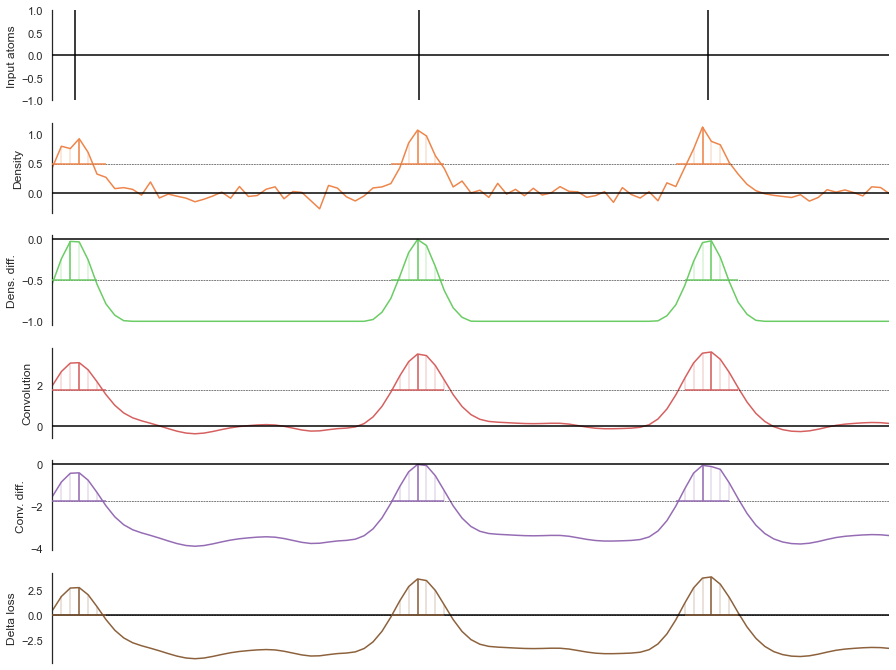

In [53]:
from scipy.signal import convolve

def get_next_atoms(points, values, threshold=None, min_dist=0):
    
    idx = np.argsort(-values, axis=None)
    points = points[idx]
    values = values[idx]
    
    if threshold is not None:
        above_thresh = values > threshold
        points = points[above_thresh]
        values = values[above_thresh]
    
    if min_dist > 0:
        
        min_dist2 = min_dist**2
        best_points = np.empty((0,1))
        best_values = np.empty((0,))
    
        for point, value in zip(points, values):
        
            dist2 = ((point - best_points)**2).sum(axis=-1)
            if all(dist2 > min_dist2):
                best_points = np.append(best_points, point[nax,...], axis=0)
                best_values = np.append(best_values, value[nax,...], axis=0)
                
        return best_points, best_values, points, values
    else:  
        return points, values, points, values

grid_dimension = 23.5
grid_points = get_grid_points(0.0, grid_dimension, resolution)[:,nax]

#atom_coords = np.array([-8.75, -5.0, 1 - radius/2, 1 + radius/2, 7.0, 7.0+bond_length])
n_atoms = np.random.randint(0, 10)
atom_coords = np.random.uniform(grid_points.min(), grid_points.max(), (n_atoms, 1))
#atom_coords = np.array([-1, 0, 1])[:,nax]*bond_length

density = get_atom_density(atom_coords[nax,:,:], atom_radius, grid_points[:,nax,:]).sum(axis=-1)
density_diff = -np.abs(1 - density)

# gen_L2_loss = 0.5 * ((true_density - gen_density)^2).sum()
# gen_L2_loss = 0.5 * (error^2).sum()
# 2*gen_L2_loss = (error^2).sum()
# 2*gen_L2_loss/density.size = (error^2).mean()
# 2*gen_L2_loss/density.size = error_var, assuming bias = 0
gen_L2_loss = 1000
error_var = 2*gen_L2_loss/(19*48*48*48)*density.size
error = np.random.normal(0, error_var, density.shape)
density += error
print(error_var)

density_norm2 = (density**2).sum()
kernel_norm2  = (kernel**2).sum()
conv = convolve(density, kernel, mode='same')

loss_init = density_norm2
loss_conv = density_norm2 + kernel_norm2 - 2*conv # polarization identity
delta_loss = -(loss_conv - loss_init)

#conv_diff = abs(dloss_conv + kernel_norm2)
#conv_diff = abs(loss_conv - loss_init + kernel_norm2)
#conv_diff = abs(loss_conv - density_norm2 + kernel_norm2)
#conv_diff = abs(density_norm2 + kernel_norm2 - 2*conv - density_norm2 + kernel_norm2)
#conv_diff = abs(kernel_norm2 - 2*conv + kernel_norm2)
conv_diff = -np.abs(kernel_norm2 - conv)

loss_actual = ((density - get_atom_density(grid_points[nax,:,:], atom_radius, grid_points[:,nax,:]))**2).sum(axis=-1)
dloss_actual = loss_actual - loss_init

metric_names = ['Input atoms', 'Density', 'Dens. diff.', 'Convolution', 'Conv. diff.', 'Delta loss']
metrics      = [None,           density,   density_diff,  conv,          conv_diff,     delta_loss]
thresholds   = [None,           0.5,      -0.5,           kernel_norm2/2, -kernel_norm2/2, 0]

n_rows = len(metrics)
height = 2
width = 15
fig, axes = plt.subplots(n_rows, 1, figsize=(width, n_rows*height),
                         gridspec_kw=dict(hspace=0.25))

for i, (name, metric, thresh) in enumerate(zip(metric_names, metrics, thresholds)):
    
    ax = axes[i]
    if i > 0:
        ax.plot(grid_points, metric, color=colors[i])
        y_min, y_max = ax.get_ylim()
        y_min = min(0, y_min)
        y_max = max(0, y_max)
        
        min_dist = 1.5*atom_radius
        atom_coords, values, atom_coords2, values2 = get_next_atoms(grid_points, metric, thresh, min_dist)
        
        ax.vlines(atom_coords2, thresh, values2, color=colors[i], linewidth=1.5, alpha=0.25)
        ax.vlines(atom_coords,  thresh, values,  color=colors[i], linewidth=1.5)
        for ac in atom_coords:
            ax.hlines(thresh, ac - min_dist/2, ac + min_dist/2, color=colors[i], linewidth=1.5, zorder=20)
    else:
        y_min, y_max = -1, 1
        ax.vlines(atom_coords, y_min, y_max, color='k')

    ax.set_xticks(grid_points)
    ax.set_xticklabels([])
    x_min, x_max = grid_points.min(), grid_points.max()
    ax.hlines(0, x_min, x_max, zorder=10)
    ax.hlines(thresh, x_min, x_max, linestyle='--', linewidth=0.5, zorder=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_ylabel(name)
    ax.grid(False)

sns.despine(fig, top=True, bottom=True, right=True)
fig.tight_layout()